/opt/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


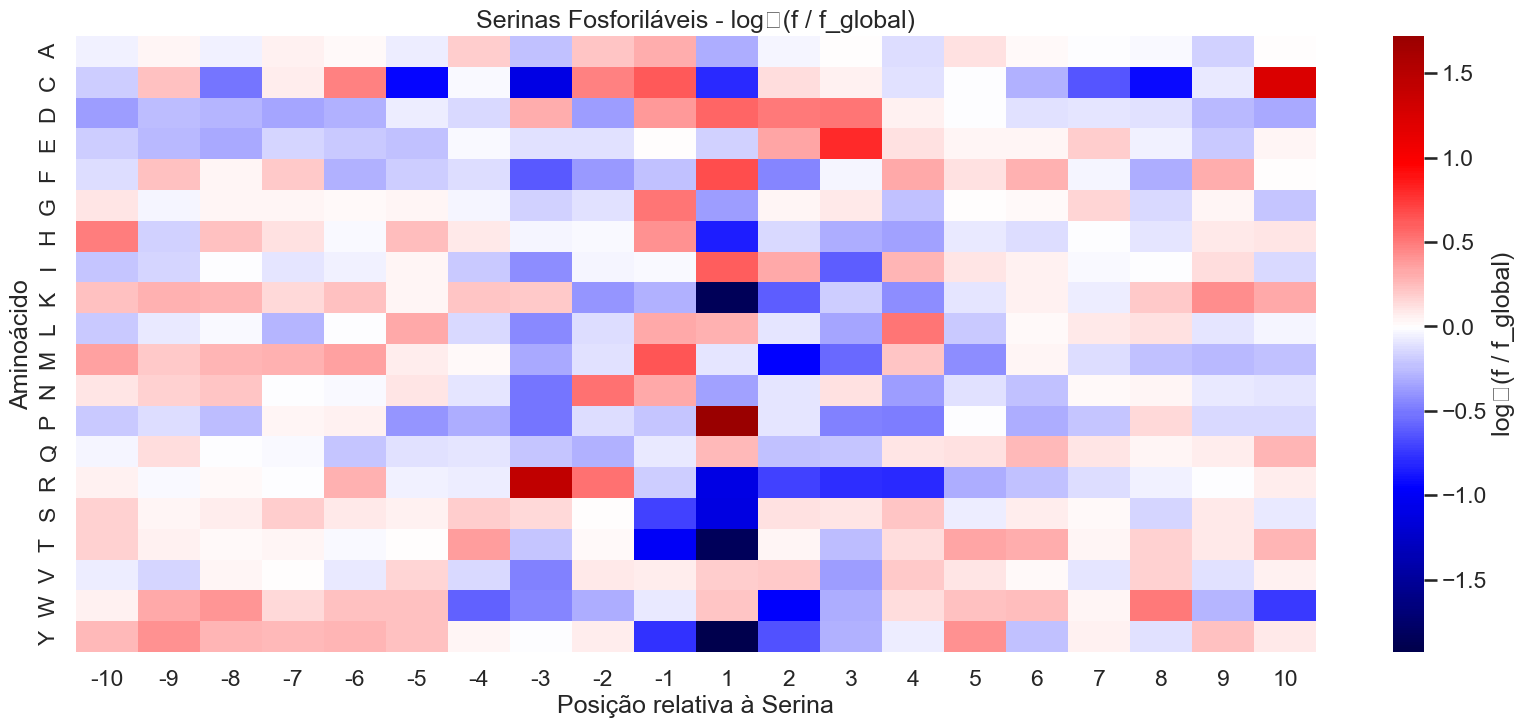

/opt/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


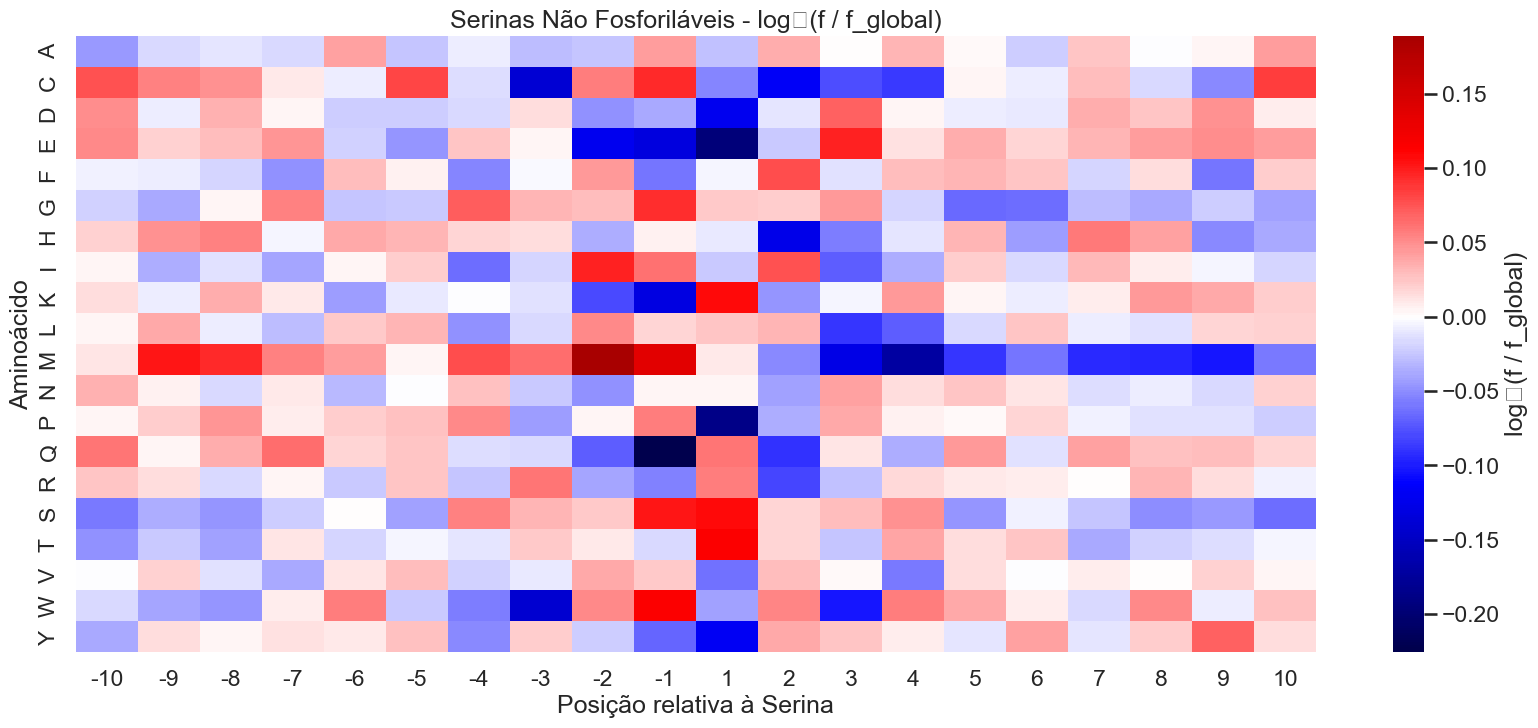

/opt/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/9h/vylh11px68l_5tmlmnf99qhr0000gn/T/ipykernel_4695/790529141.py:108: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


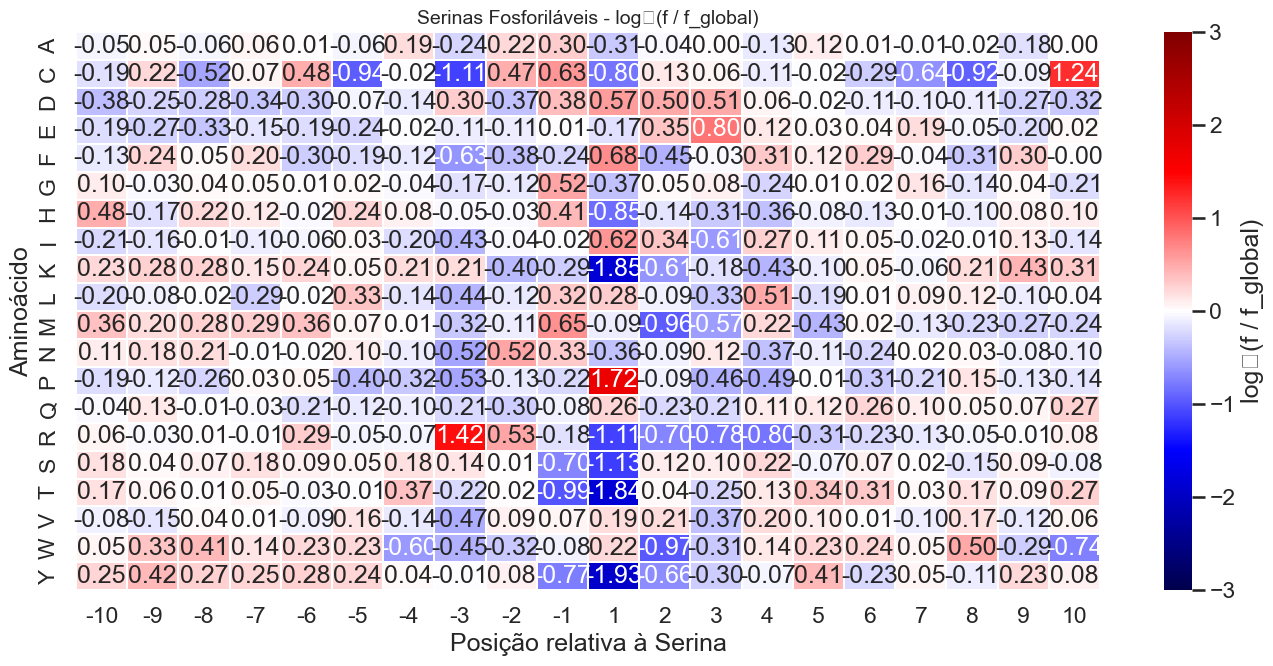

/opt/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/9h/vylh11px68l_5tmlmnf99qhr0000gn/T/ipykernel_4695/790529141.py:108: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


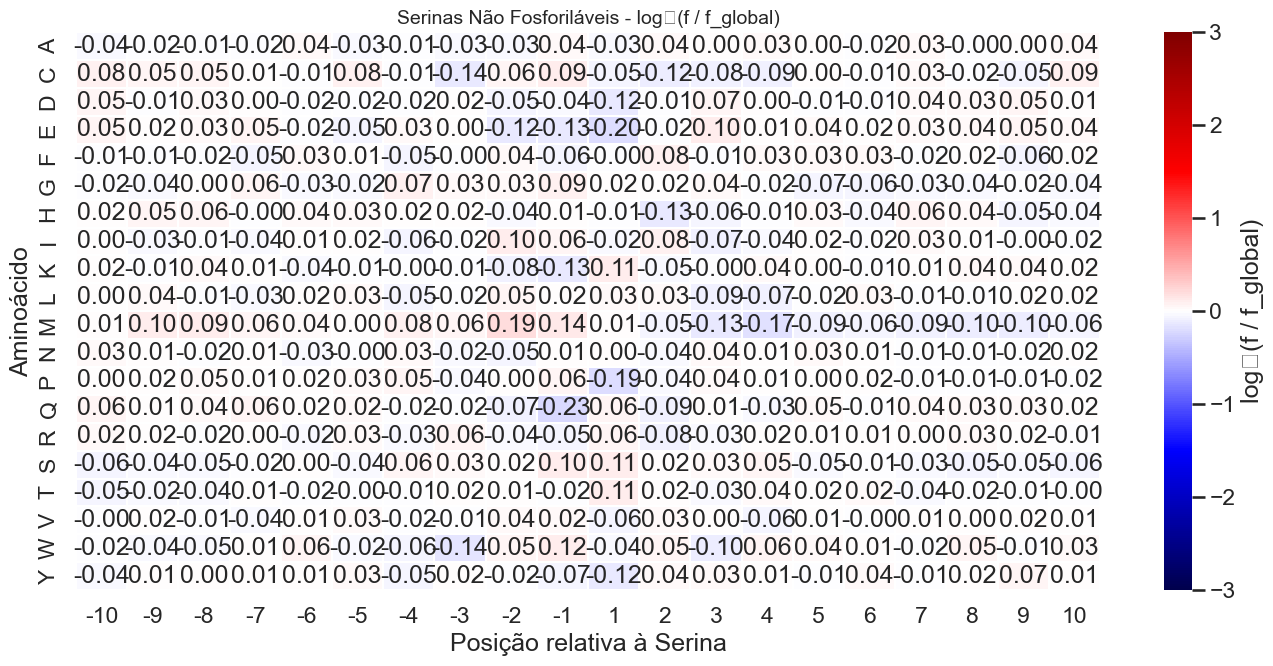

Shape treino codificado: (7751, 20)
Shape teste codificado: (3322, 20)
Distribuição treino: known P
False    4073
True     3678
Name: count, dtype: int64
Distribuição teste: known P
False    1745
True     1577
Name: count, dtype: int64
Accuracy: 0.516255267910897

Matriz de Confusão:
[[ 319 1426]
 [ 181 1396]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.64      0.18      0.28      1745
        True       0.49      0.89      0.63      1577

    accuracy                           0.52      3322
   macro avg       0.57      0.53      0.46      3322
weighted avg       0.57      0.52      0.45      3322



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

features = pd.read_csv("uniprotkb_s_cerevisiae.gff", sep='\t', comment='#', header=None, low_memory=False)
features.columns = ['Entry', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes', 'extra']

seq_df = pd.read_csv("uniprotkb_s_cerevisiae.tsv", sep="\t", usecols=["Entry", "Sequence"])

def filtrar_fosfoserinas(features):
    fosfo = features[
        (features["type"] == "Modified residue") &
        (features["attributes"].str.contains("Phosphoserine", case=False, na=False))
    ]
    fosfo_dict = {}
    for _, row in fosfo.iterrows():
        entry = row["Entry"]
        pos = int(row["start"])
        fosfo_dict.setdefault(entry, set()).add(pos)
    return fosfo_dict

fosfo_dict = filtrar_fosfoserinas(features)

def extrair_serinas(seq_df, fosfo_dict):
    records = []
    for _, row in seq_df.iterrows():
        entry = row["Entry"]
        seq = row["Sequence"]
        fosfo_pos = fosfo_dict.get(entry, set())
        for i, aa in enumerate(seq):
            if aa == 'S':
                pos_1based = i + 1
                known_P = pos_1based in fosfo_pos
                window = [seq[i + offset] if 0 <= i + offset < len(seq) else 'X' for offset in range(-10, 11)]
                records.append([entry, pos_1based, known_P] + window)
    return records

records = extrair_serinas(seq_df, fosfo_dict)

def construir_dataframe(records):
    columns = ["entry", "pos", "known P"] + [str(i) for i in range(-10, 11)]
    return pd.DataFrame(records, columns=columns)

df_serinas = construir_dataframe(records)

df_knownP = df_serinas[df_serinas["known P"] == True]
df_notP = df_serinas[df_serinas["known P"] == False]

def calcular_log2_frequencias(df):
    posicoes = [str(i) for i in range(-10, 11) if i != 0]
    aminoacidos = list("ACDEFGHIKLMNPQRSTVWY")

    aa_counts_global = pd.Series(0, index=aminoacidos, dtype=int)
    for pos in posicoes:
        aa_counts_global += df[pos].value_counts().reindex(aminoacidos, fill_value=0)

    total_global = aa_counts_global.sum()
    f_global = aa_counts_global / total_global

    log2_matrix = pd.DataFrame(index=aminoacidos, columns=posicoes, dtype=float)
    for pos in posicoes:
        counts = df[pos].value_counts().reindex(aminoacidos, fill_value=0)
        f_pos = counts / counts.sum()
        log2_matrix[pos] = np.log2(f_pos / f_global)

    return log2_matrix

log2_knownP = calcular_log2_frequencias(df_knownP)
log2_notP = calcular_log2_frequencias(df_notP)

plt.figure(figsize=(20, 8))
sns.heatmap(log2_knownP, cmap="seismic", center=0, cbar_kws={"label": "log₂(f / f_global)"})
plt.title("Serinas Fosforiláveis - log₂(f / f_global)")
plt.xlabel("Posição relativa à Serina")
plt.ylabel("Aminoácido")
plt.show()

plt.figure(figsize=(20, 8))
sns.heatmap(log2_notP, cmap="seismic", center=0, cbar_kws={"label": "log₂(f / f_global)"})
plt.title("Serinas Não Fosforiláveis - log₂(f / f_global)")
plt.xlabel("Posição relativa à Serina")
plt.ylabel("Aminoácido")
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

def plotar_heatmap(df_log2, titulo):
    plt.figure(figsize=(14, 7))
    sns.heatmap(
        df_log2,
        cmap="seismic",
        center=0,
        vmin=-3,
        vmax=3,
        annot=True,
        fmt=".2f",
        linewidths=0.1,
        cbar_kws={'label': 'log₂(f / f_global)'}
    )
    plt.title(titulo, fontsize=14)
    plt.xlabel("Posição relativa à Serina")
    plt.ylabel("Aminoácido")
    plt.tight_layout()
    plt.show()

# Plot para serinas fosforiláveis
plotar_heatmap(log2_knownP, "Serinas Fosforiláveis - log₂(f / f_global)")

# Plot para serinas não fosforiláveis
plotar_heatmap(log2_notP, "Serinas Não Fosforiláveis - log₂(f / f_global)")

#Tarefa 3

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df_knownP = df_serinas[df_serinas["known P"] == True]
df_notP = df_serinas[df_serinas["known P"] == False]

np.random.seed(10)
df_notP = df_serinas.loc[~df_serinas["known P"], :]
indexes2drop = np.random.choice(df_notP.index, 253000, replace = False)
df_notP_reduced = df_notP.drop(indexes2drop)


serine_table_balanced = pd.concat([df_knownP, df_notP_reduced])

X = serine_table_balanced [[str(i) for i in range(-10, 11)]]
Y = serine_table_balanced ["known P"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size = 0.3, stratify = Y, random_state = 42
)

def calcular_log2_freq(df):
    aa_list = list("ACDEFGHIKLMNPQRSTVWY")
    posicoes = [str(i) for i in range (-10, 11) if i !="0"]
    aa_counts_global = pd.Series (0, index = aa_list, dtype = int)

    for pos in posicoes:
        aa_counts_global += df[pos].value_counts().reindex (aa_list, fill_value = 0)

    f_global = aa_counts_global / aa_counts_global.sum()
    f_global = f_global.replace (0, 1e-10)

    log2_matrix = pd.DataFrame (index = aa_list, columns = posicoes, dtype = float)
    for pos in posicoes:
        counts = df[pos].value_counts().reindex(aa_list, fill_value = 0)
        f_pos = counts / counts.sum()
        f_pos = f_pos.replace (0, 1e-10)
        log2_matrix[pos] = np.log2(f_pos / f_global)
    return log2_matrix

log2P = calcular_log2_freq(X_train[Y_train == True])
log2notP = calcular_log2_freq(X_train[Y_train == False])

def codificar_df (df, Y_vals, tabela_P, tabela_notP):
    codificados =[]
    posicoes = [str(i) for i in range (-10, 11) if i != 0]
    aminoacidos_validos = set(tabela_P.index)

    for idx, row in df.iterrows():
        knownP = Y_vals.loc[idx]
        tabela = tabela_P if knownP else tabela_notP
        linha = []
        for pos in posicoes:
            aa = row[pos]
            if aa in aminoacidos_validos:
                linha.append(tabela.loc[aa, pos])
            else:
                linha.append(0.0)
        codificados.append (linha)
    
    return pd.DataFrame (codificados, index = df.index, columns = posicoes)

X_train_encoded = codificar_df (X_train, Y_train, log2P, log2notP)

def codificar_sem_label(df, tabela_P, tabela_notP):
    codificados = []
    posicoes = [str(i) for i in range(-10, 11) if i != 0]
    aminoacidos_validos = set (tabela_P.index)

    for _, row in df.iterrows():
        linha = []
        for pos in posicoes:
            aa = row[pos]
            if aa in aminoacidos_validos:
                val = (tabela_P.loc[aa, pos] + tabela_notP.loc [aa, pos]) / 2
                linha.append(val)

            else:
                linha.append(0.0)

        codificados.append(linha)

    return pd.DataFrame(codificados, index=df.index, columns=posicoes)

X_test_encoded = codificar_sem_label(X_test, log2P, log2notP)

print("Shape treino codificado:", X_train_encoded.shape)
print("Shape teste codificado:", X_test_encoded.shape)
print("Distribuição treino:", Y_train.value_counts())
print("Distribuição teste:", Y_test.value_counts())

# Tarefa 4

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_encoded, Y_train)

Y_pred = modelo_rf.predict(X_test_encoded)

print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(Y_test, Y_pred))
print("\nRelatório de Classificação:")
print(classification_report(Y_test, Y_pred))